# PyORBIT Indirect Space Charge

### Adding a boundary in slice-by-slice 2D FFT Poisson solver to calculate indirect space charge 

- Using MD4224 (6.24, 6.10) working point as an example
- Observation point (s=0) is at BWSV64, the vertical wire-scanner

### imports

In [63]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import floor, log10

#! pip install --user wand
#import wand
from wand.image import Image as WImage

### Function Definitions

In [64]:
# Function to print lines between min_ and max_ values
def print_some_lines(line_list, min_, max_):
    j = 0
    for i in madx_simulation_lines:
        if (j <= max_) and (j >= min_):
            print i
        j = j + 1
    return

print_all_lines = lambda x: sys.stdout.write("\n".join(x) + "\n")


In [65]:
def round_sig(x, sig=3):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [66]:
########################################################################
# Read PTC Twiss and return dictionary of columns/values
########################################################################
def Read_PTC_Twiss_Return_Dict(filename, verbose=True):
    # Dictionary for output
    d = dict()
    d['HEADER_FILENAME'] = [filename]
    keywords = ''
    
    # First we open and count header lines
    fin0=open(filename,'r').readlines()
    headerlines = 0
    for l in fin0:
        # Store each header line
        headerlines = headerlines + 1
        # Stop if we find the line starting '* NAME'
        if '* NAME' in l:
            keywords = l
            break
        # Store the headers as d['HEADER_<name>'] = <value>
        else:
            #try:
            #    d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]     
            #except ValueError:
            #    d[str('HEADER_'+l.split()[1])]=[str(l.split()[-1])]   
            if '"' in l:
                d[str('HEADER_'+l.split()[1])]=[str(l.split('"')[1])]
            else:
                d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]                 
    headerlines = headerlines + 1    
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict found Keywords: \n',keywords
    
    # Make a list of column keywords to return (as an aid to iterating)
    dict_keys = []
    for key in keywords.split():
        dict_keys.append(key)
    dict_keys.remove('*')
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict Dict Keys: \n',dict_keys
    
    # Initialise empty dictionary entries for column keywords 
    for key in dict_keys:
        d[key]=[]
        
    if verbose: 
        print '\nRead_PTC_Twiss_Return_Dict header only dictionary \n'
        for i in d:
            print i, d[i]
    
    # Strip header
    fin1=open(filename,'r').readlines()[headerlines:]   
    
    # Populate the dictionary line by line
    for l in fin1:
        i = -1        
        for value in l.split():
            i = i+1
            if 'NAME' in dict_keys[i]:
                d[dict_keys[i]].append(str(value))
            else:
                d[dict_keys[i]].append(float(value))    
                
    # Return list of column keywords 'dict_keys', and dictionary 'd'
    return dict_keys, d

### Plot Parameters

In [67]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 1.5

In [68]:
save_folder = 'Plots/'

legend_label = 'Case'
main_label = 'Indirect Space Charge'

# Step 1: Run MAD-X (V5.02.00) to obtain PTC Twiss

## We will run 4 cases, all with the same tune (6.21, 6.10):

1. Control tune with Low Energy Quadrupoles (LEQs)
1. Control tune with Pole Face Windings (PFWs)
1. Control tune with Pole Face Windings (PFWs) + Single quadrupolar error on QDN72 generating vertical beta-beating of similar magnitude to LEQs
1. Control tune with Pole Face Windings (PFWs) + distributed quadrupolar on 20 QDN LEQs error generating vertical beta-beating of similar magnitude to LEQs
1. Control tune with Pole Face Windings (PFWs) this time including higher order field components in the modelling of the PFW (other simulations use up to quadrupole in PFW)


- Remember that for this version of MAD-X all PTC-Twiss dispersion values should be normalised by $\beta = \frac{v}{c}$ = 0.9158 for 1.4 GeV Run 2 PS Injection simulations such as this

In [69]:
madx_command = './madx-linux64 < LEQ_Flat_file.madx'
os.system(madx_command)
d_LEQ_keys, d_LEQ = Read_PTC_Twiss_Return_Dict('leq_flat_file.tfs')


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                  X                 PX                  Y                 PY                MU1                MU2 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'X', 'PX', 'Y', 'PY', 'MU1', 'MU2']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342599162]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.04248161]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [28.94231883]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02697850494]
HEADER_BETA_X_MAX [24.54387774]
HEADER_BETA_X_MIN [11.04248161]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

In [70]:
print 'LEQ lattice (fractional) Tunes = (', round_sig(d_LEQ['HEADER_Q1'][0],4), ',', round_sig(d_LEQ['HEADER_Q2'][0],4), ')' 

LEQ lattice (fractional) Tunes = ( 0.2095 , 0.1001 )


In [71]:
madx_command = './madx-linux64 < PFW_Flat_file.madx'
os.system(madx_command)
d_PFW_keys, d_PFW = Read_PTC_Twiss_Return_Dict('pfw_flat_file.tfs')


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                  X                 PX                  Y                 PY                MU1                MU2 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'X', 'PX', 'Y', 'PY', 'MU1', 'MU2']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342334435]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.83378405]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [23.01757]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02700497767]
HEADER_BETA_X_MAX [22.59313908]
HEADER_BETA_X_MIN [11.83378405]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PTC-P

In [72]:
print 'PFW lattice (fractional) Tunes = (', round_sig(d_PFW['HEADER_Q1'][0],4), ',', round_sig(d_PFW['HEADER_Q2'][0],4), ')' 

PFW lattice (fractional) Tunes = ( 0.2095 , 0.1001 )


In [73]:
madx_command = './madx-linux64 < PFW_Single_Quad_Error_Flat_file.madx'
os.system(madx_command)
d_PFW_Single_keys, d_PFW_Single = Read_PTC_Twiss_Return_Dict('pfw_single_quad_error_flat_file.tfs')


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                  X                 PX                  Y                 PY                MU1                MU2 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'X', 'PX', 'Y', 'PY', 'MU1', 'MU2']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342303428]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.12327342]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [27.95659046]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02700807837]
HEADER_BETA_X_MAX [24.01429574]
HEADER_BETA_X_MIN [11.12327342]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

In [74]:
print 'PFW + Single Quadrupole Error lattice (fractional) Tunes = (', round_sig(d_PFW_Single['HEADER_Q1'][0],4), ',', round_sig(d_PFW_Single['HEADER_Q2'][0],4), ')' 

PFW + Single Quadrupole Error lattice (fractional) Tunes = ( 0.2095 , 0.1001 )


In [75]:
madx_command = './madx-linux64 < PFW_Distributed_Quad_Error_Flat_file.madx'
os.system(madx_command)
d_PFW_Distributed_keys, d_PFW_Distributed = Read_PTC_Twiss_Return_Dict('pfw_distributed_quad_error_flat_file.tfs')


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                  X                 PX                  Y                 PY                MU1                MU2 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'X', 'PX', 'Y', 'PY', 'MU1', 'MU2']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342369168]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [10.97875576]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [29.55551396]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02700150438]
HEADER_BETA_X_MAX [24.19952736]
HEADER_BETA_X_MIN [10.97875576]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

In [76]:
print 'PFW + Single Quadrupole Error lattice (fractional) Tunes = (', round_sig(d_PFW_Distributed['HEADER_Q1'][0],4), ',', round_sig(d_PFW_Distributed['HEADER_Q2'][0],4), ')' 

PFW + Single Quadrupole Error lattice (fractional) Tunes = ( 0.2095 , 0.1001 )


In [96]:
madx_command = './madx-linux64 < PFW_Nonlinear_Flat_file.madx'
os.system(madx_command)
d_PFW_nonlin_keys, d_PFW_nonlin = Read_PTC_Twiss_Return_Dict('pfw_nonlinear_flat_file.tfs')


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                  X                 PX                  Y                 PY                MU1                MU2 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'X', 'PX', 'Y', 'PY', 'MU1', 'MU2']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342334435]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.83378405]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [23.01757]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02700497767]
HEADER_BETA_X_MAX [22.59313909]
HEADER_BETA_X_MIN [11.83378405]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PTC-P

In [97]:
print 'PFW Non-Linear lattice (fractional) Tunes = (', round_sig(d_PFW_nonlin['HEADER_Q1'][0],4), ',', round_sig(d_PFW_nonlin['HEADER_Q2'][0],4), ')' 

PFW Non-Linear lattice (fractional) Tunes = ( 0.2095 , 0.1001 )


# Compare beta beating

### First check that the phase advance in each plane is the same for all lattices

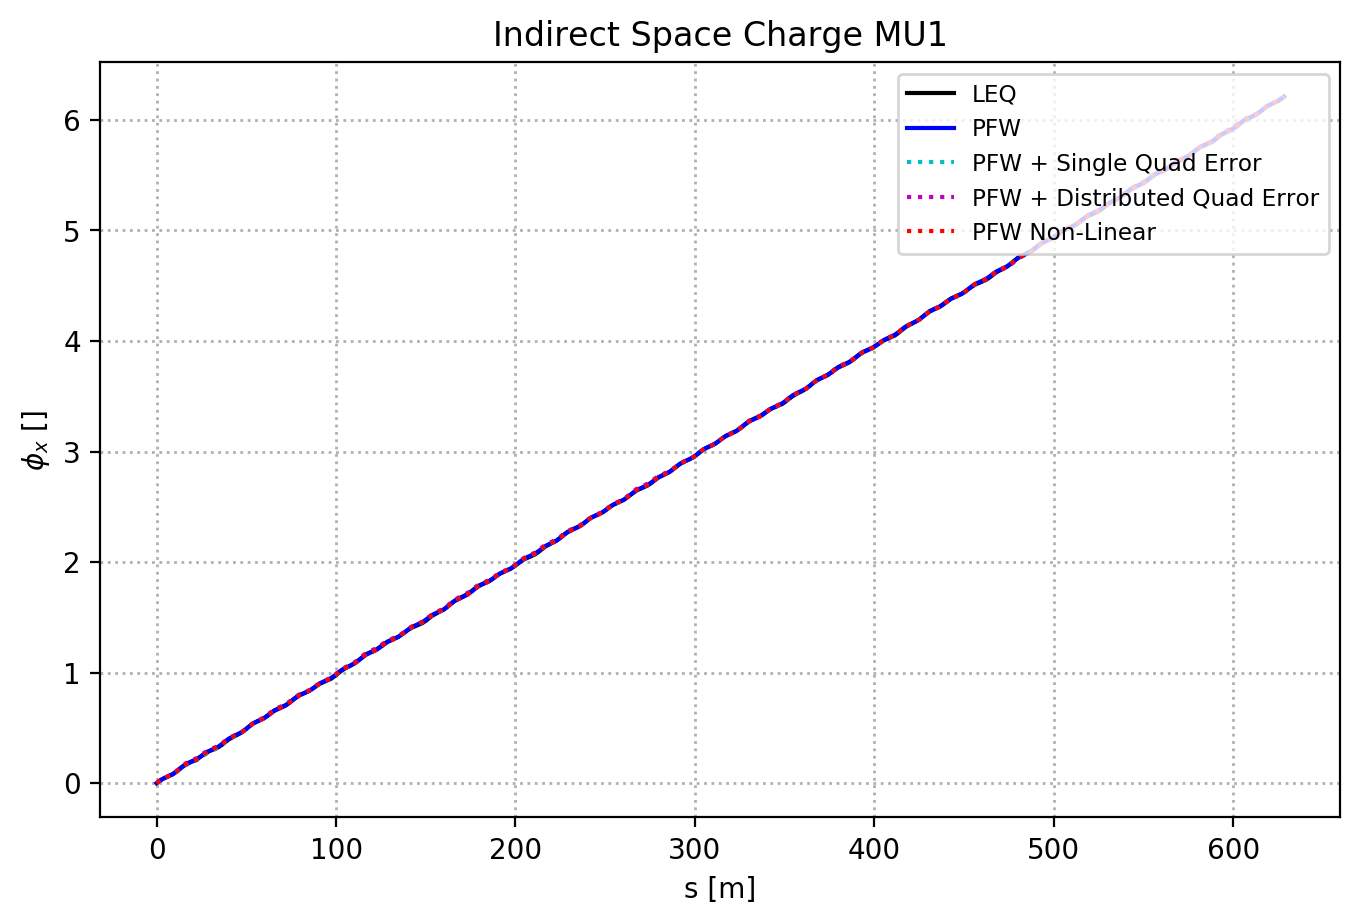

In [100]:
parameter = 'MU1'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\phi_x$ []');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
      
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

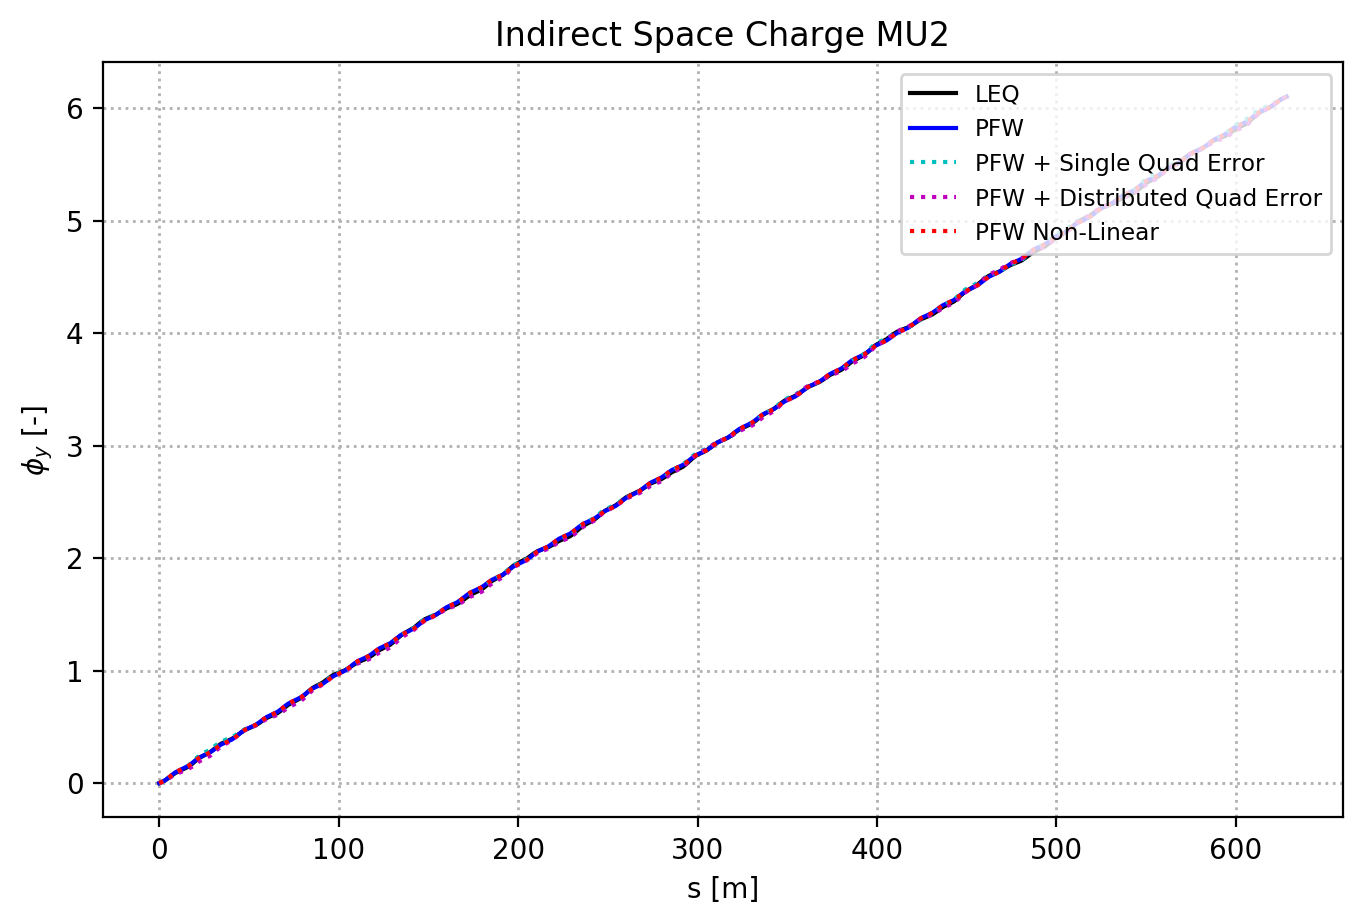

In [101]:
parameter = 'MU2'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\phi_y$ [-]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

### Horizontal beta-beating for LEQ and PFQ cases with quadrupolar errors are of similar magnitude. 

### There is no beta-beating for the non-linear PFW case

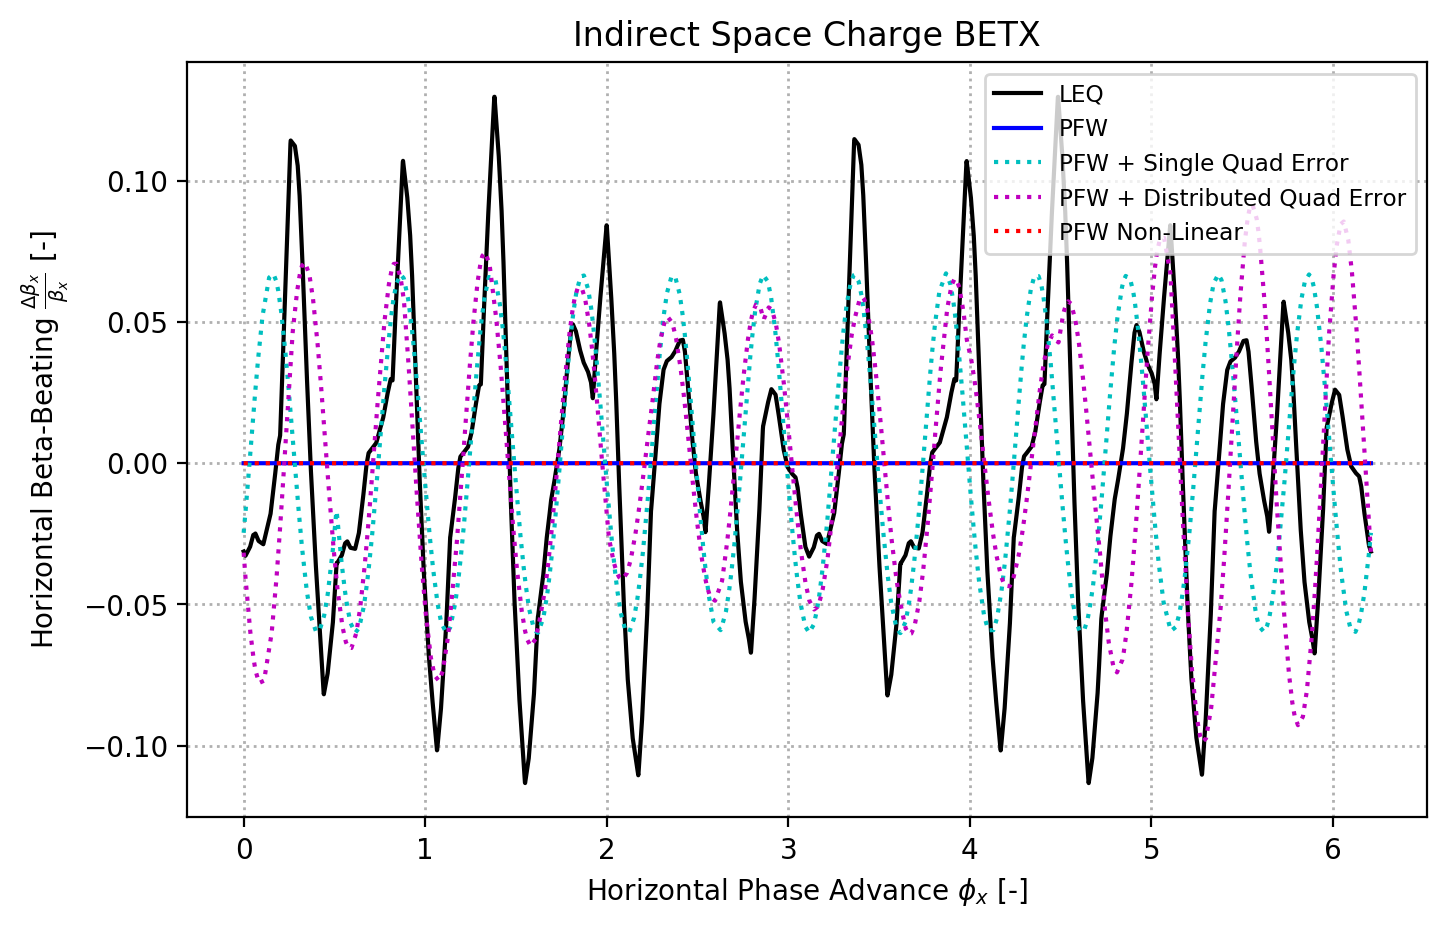

In [102]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel(r'Horizontal Phase Advance $\phi_x$ [-]');
ax1.set_ylabel(r'Horizontal Beta-Beating $\frac{\Delta \beta_x}{\beta_{x}}$ [-]');

x1 = np.array(d_LEQ['MU1'])
y1 = (np.array(d_LEQ[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x1, y1, label='LEQ', color='k');

x2 = np.array(d_PFW['MU1'])
y2 = (np.array(d_PFW[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x2, y2, label='PFW', color='b');

x3 = np.array(d_PFW_Single['MU1'])
y3 = (np.array(d_PFW_Single[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x3, y3, label='PFW + Single Quad Error', color='c', ls=':');

x4 = np.array(d_PFW_Distributed['MU1'])
y4 = (np.array(d_PFW_Distributed[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x4, y4, label='PFW + Distributed Quad Error', color='m', ls=':');

x5 = np.array(d_PFW_nonlin['MU1'])
y5 = (np.array(d_PFW_nonlin[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x5, y5, label='PFW Non-Linear', color='r', ls=':');
           
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_Horizontal_Beta_Beating.png'
plt.savefig(savename, dpi = 200);

### Vertical beta-beating is constructed to be of similar amplitude to LEQs (rounded to ~ 20%)


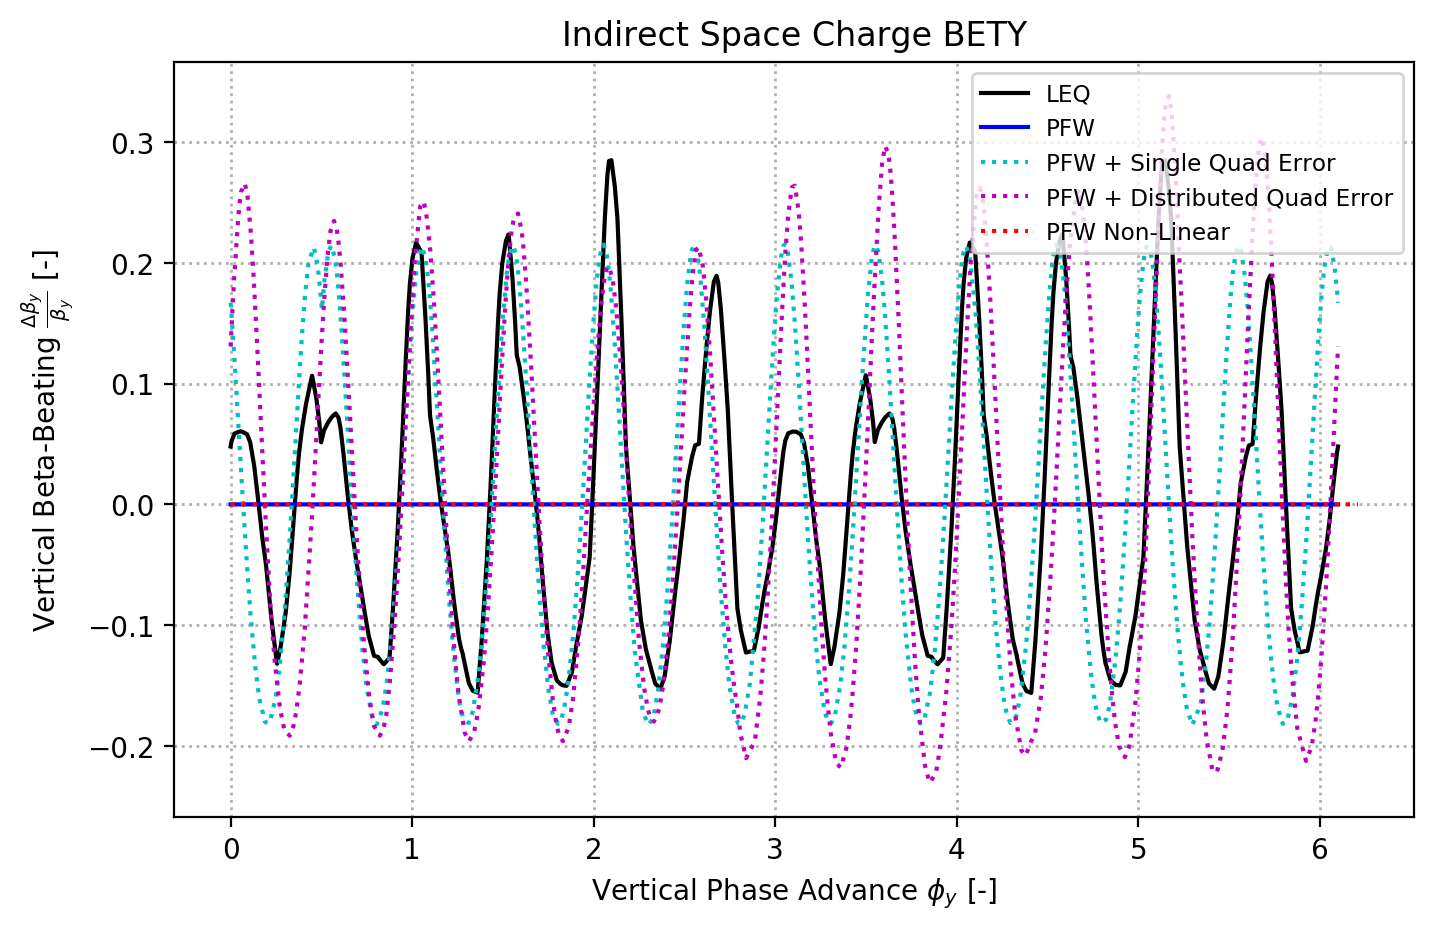

In [119]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel(r'Vertical Phase Advance $\phi_y$ [-]');
ax1.set_ylabel(r'Vertical Beta-Beating $\frac{\Delta \beta_y}{\beta_{y}}$ [-]');

x1 = np.array(d_LEQ['MU2'])
y1 = (np.array(d_LEQ[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x1, y1, label='LEQ', color='k');

x2 = np.array(d_PFW['MU2'])
y2 = (np.array(d_PFW[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x2, y2, label='PFW', color='b');

x3 = np.array(d_PFW_Single['MU2'])
y3 = (np.array(d_PFW_Single[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x3, y3, label='PFW + Single Quad Error', color='c', ls=':');

x4 = np.array(d_PFW_Distributed['MU2'])
y4 = (np.array(d_PFW_Distributed[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x4, y4, label='PFW + Distributed Quad Error', color='m', ls=':');

x5 = np.array(d_PFW_nonlin['MU1'])
y5 = (np.array(d_PFW_nonlin[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x5, y5, label='PFW Non-Linear', color='r', ls=':');
         
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '__Vertical_Beta_Beating.png'
plt.savefig(savename, dpi = 200);

### we can see the position of the single quadruoplar kick between 0 and 1 in vertical phase advance

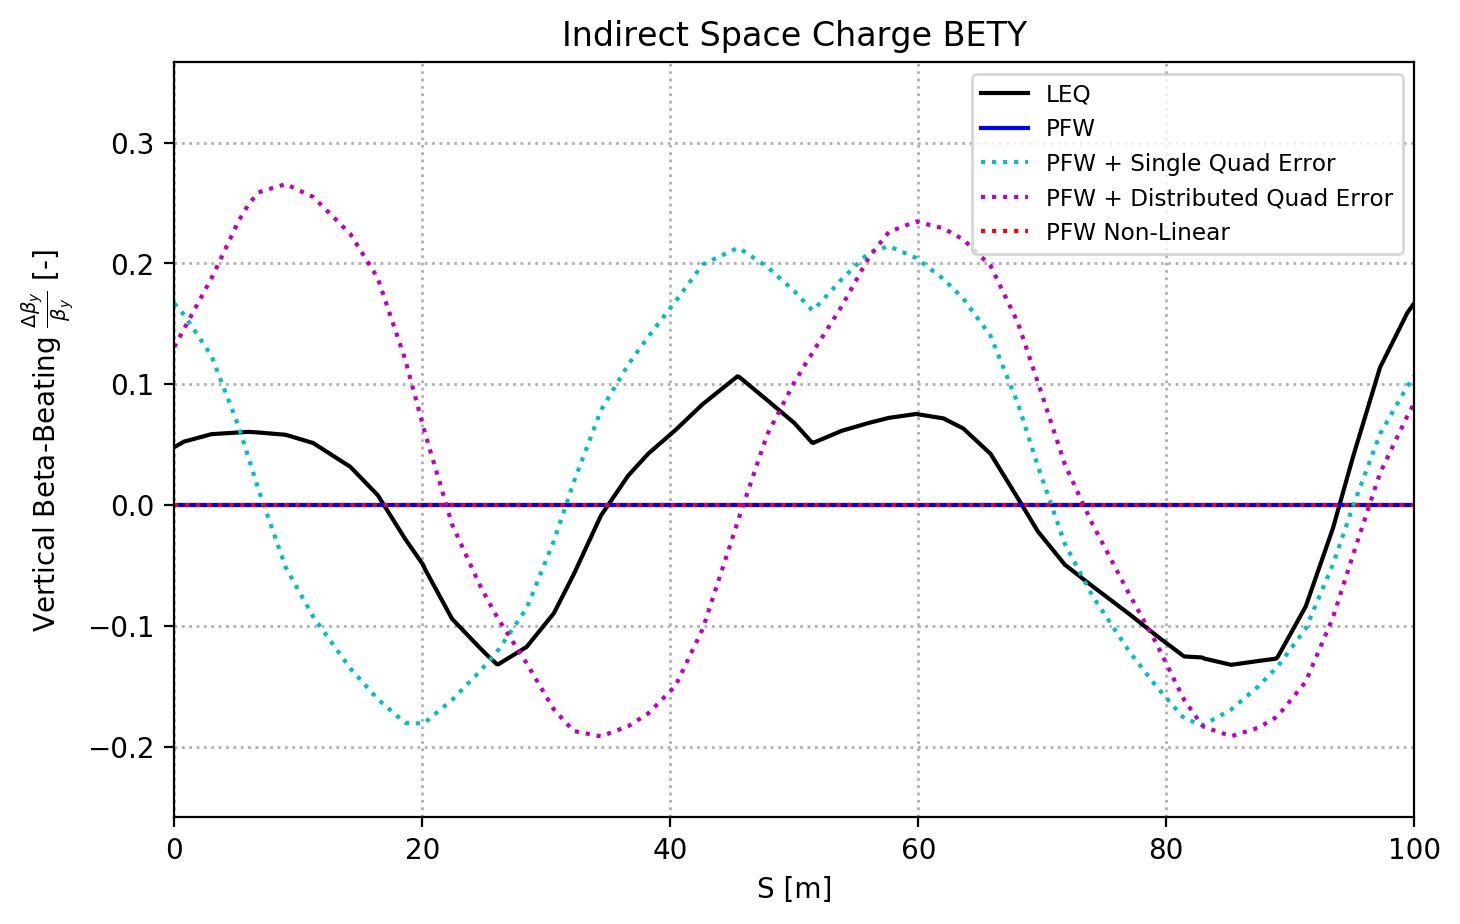

In [104]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('S [m]');
ax1.set_ylabel(r'Vertical Beta-Beating $\frac{\Delta \beta_y}{\beta_{y}}$ [-]');

x1 = np.array(d_LEQ['S'])
y1 = (np.array(d_LEQ[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x1, y1, label='LEQ', color='k');

x2 = np.array(d_PFW['S'])
y2 = (np.array(d_PFW[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x2, y2, label='PFW', color='b');

x3 = np.array(d_PFW_Single['S'])
y3 = (np.array(d_PFW_Single[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x3, y3, label='PFW + Single Quad Error', color='c', ls=':');

x4 = np.array(d_PFW_Distributed['S'])
y4 = (np.array(d_PFW_Distributed[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x4, y4, label='PFW + Distributed Quad Error', color='m', ls=':');

x5 = np.array(d_PFW_nonlin['S'])
y5 = (np.array(d_PFW_nonlin[parameter])-np.array(d_PFW[parameter]))/np.array(d_PFW[parameter])
ax1.plot(x5, y5, label='PFW Non-Linear', color='r', ls=':');
         
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0,100)

savename = save_folder + '/'+ main_label + '__Vertical_Beta_Beating_QDN.png'
plt.savefig(savename, dpi = 200);

# Step 2: Plot to compare optics

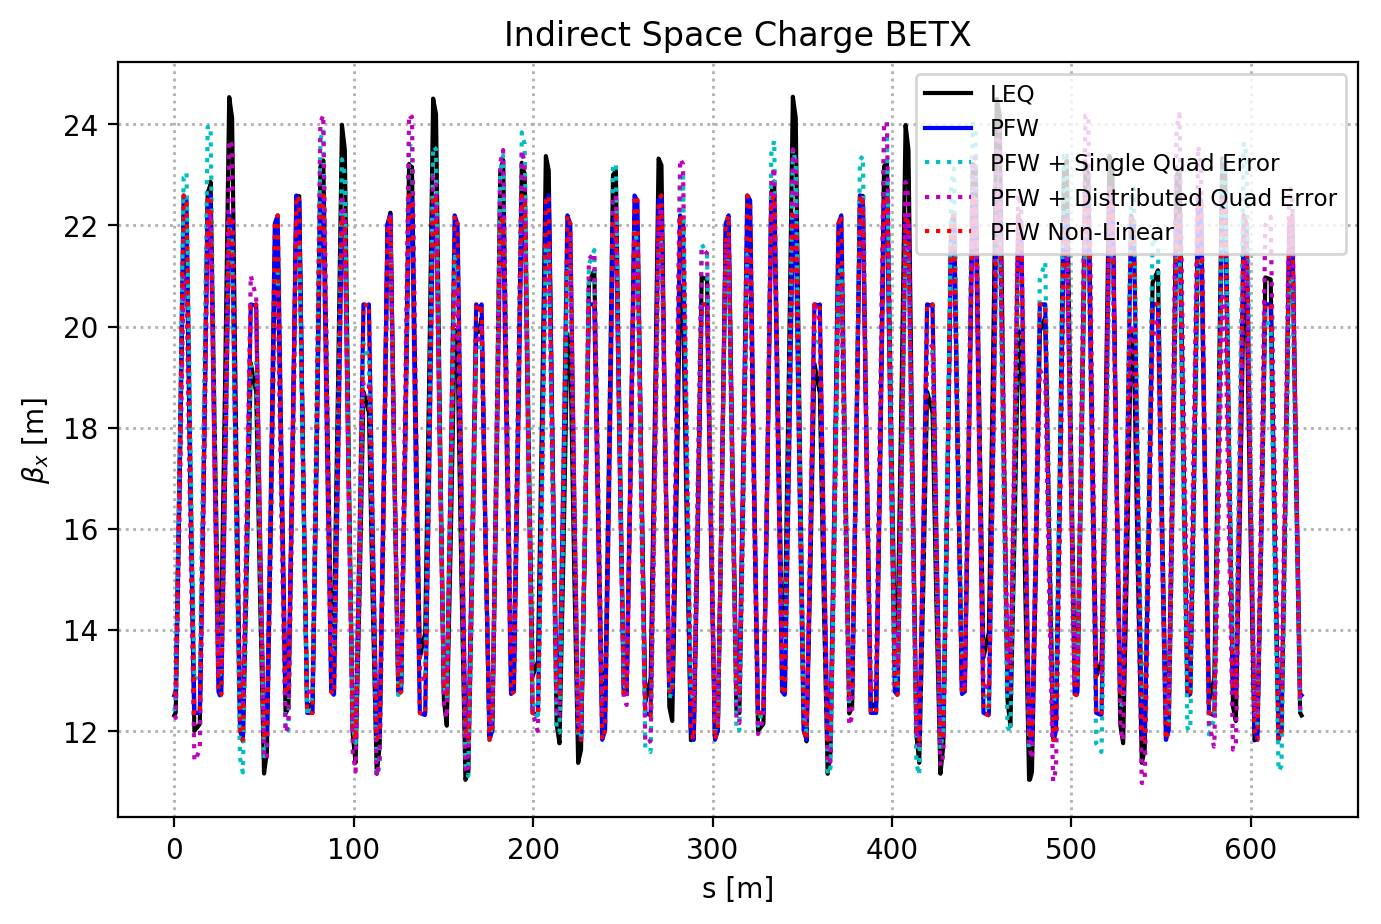

In [105]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_x$ [m]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

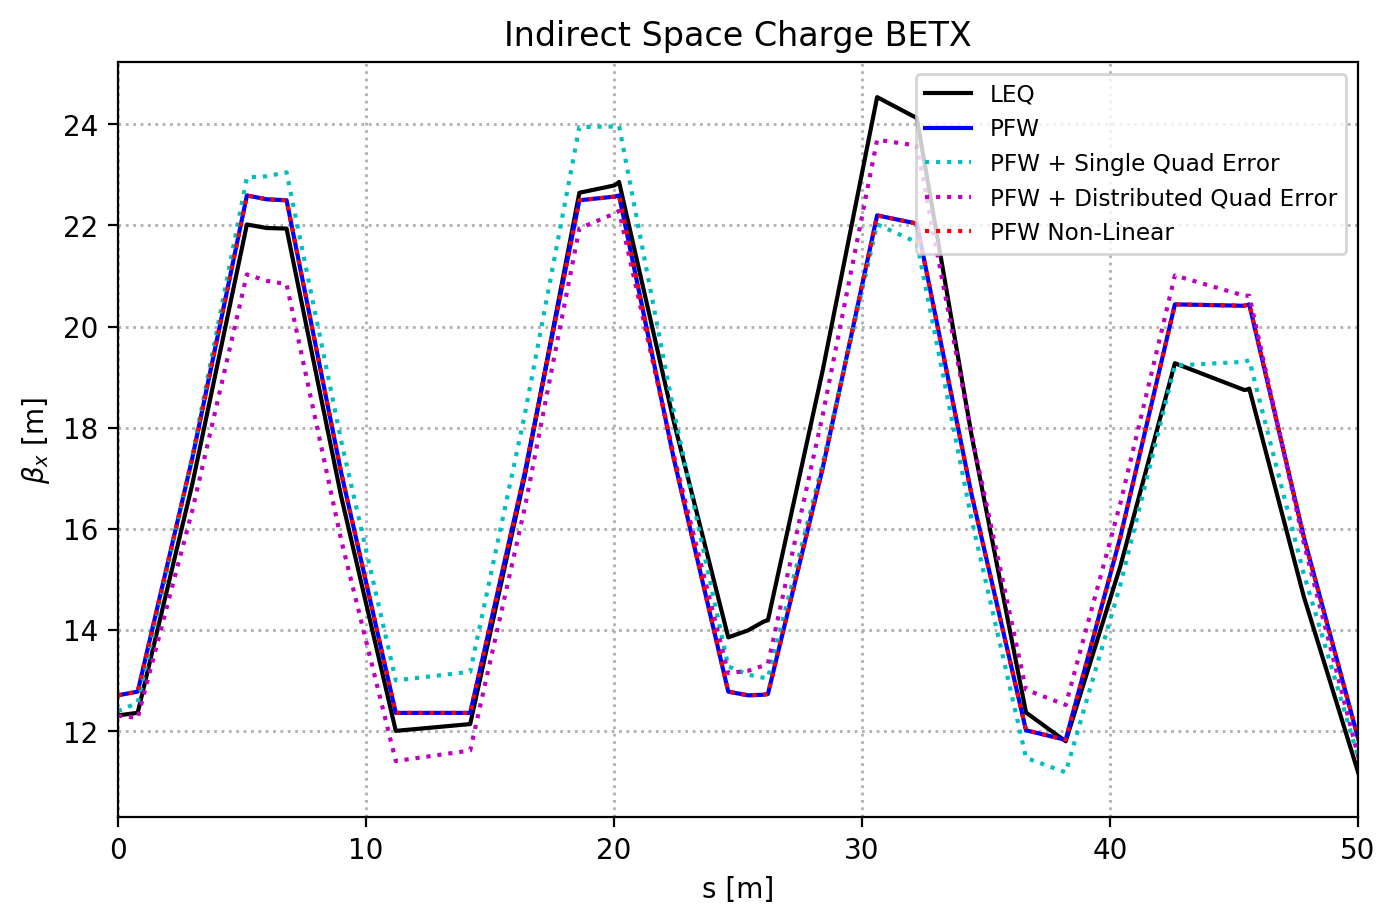

In [106]:
parameter = 'BETX'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_x$ [m]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0,50)

savename = save_folder + '/'+ main_label + '_' + parameter + 'zoom.png'
plt.savefig(savename, dpi = 200);

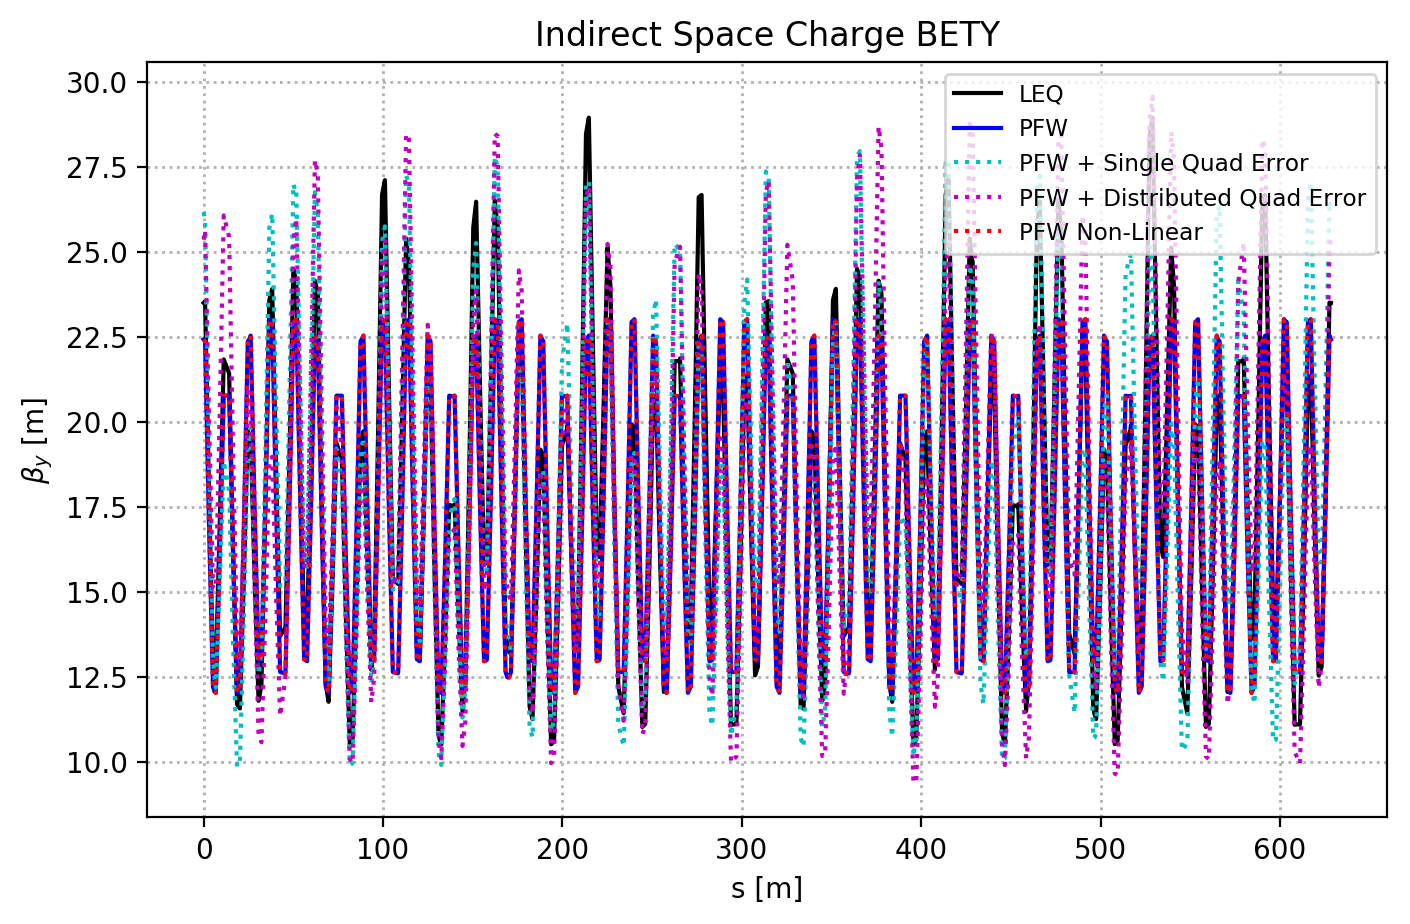

In [107]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_y$ [m]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

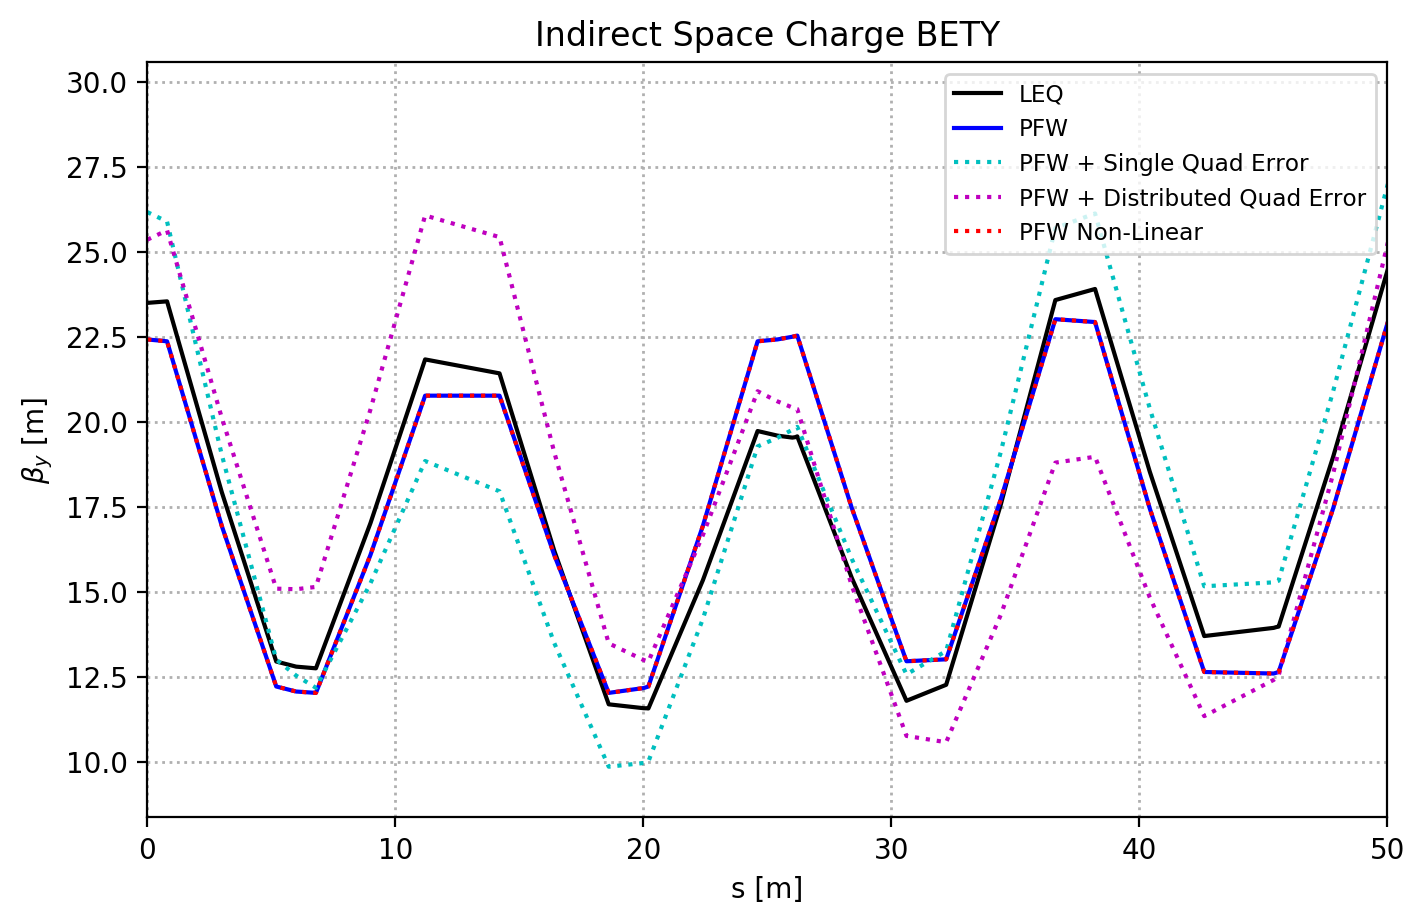

In [108]:
parameter = 'BETY'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\beta_y$ [m]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0,50)

savename = save_folder + '/'+ main_label + '_' + parameter + 'zoom.png'
plt.savefig(savename, dpi = 200);

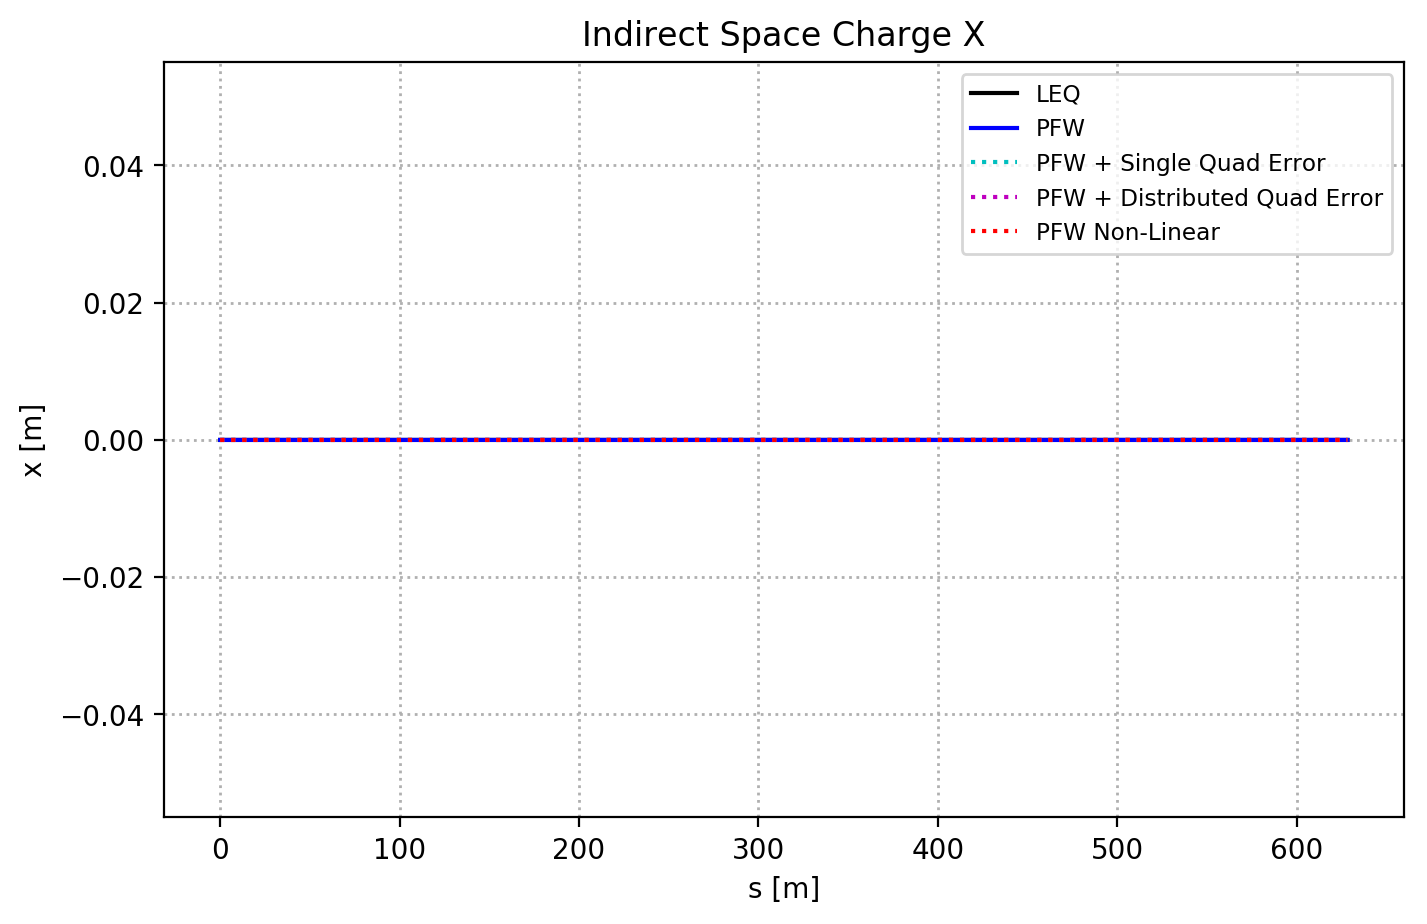

In [109]:
parameter = 'X'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel('x [m]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

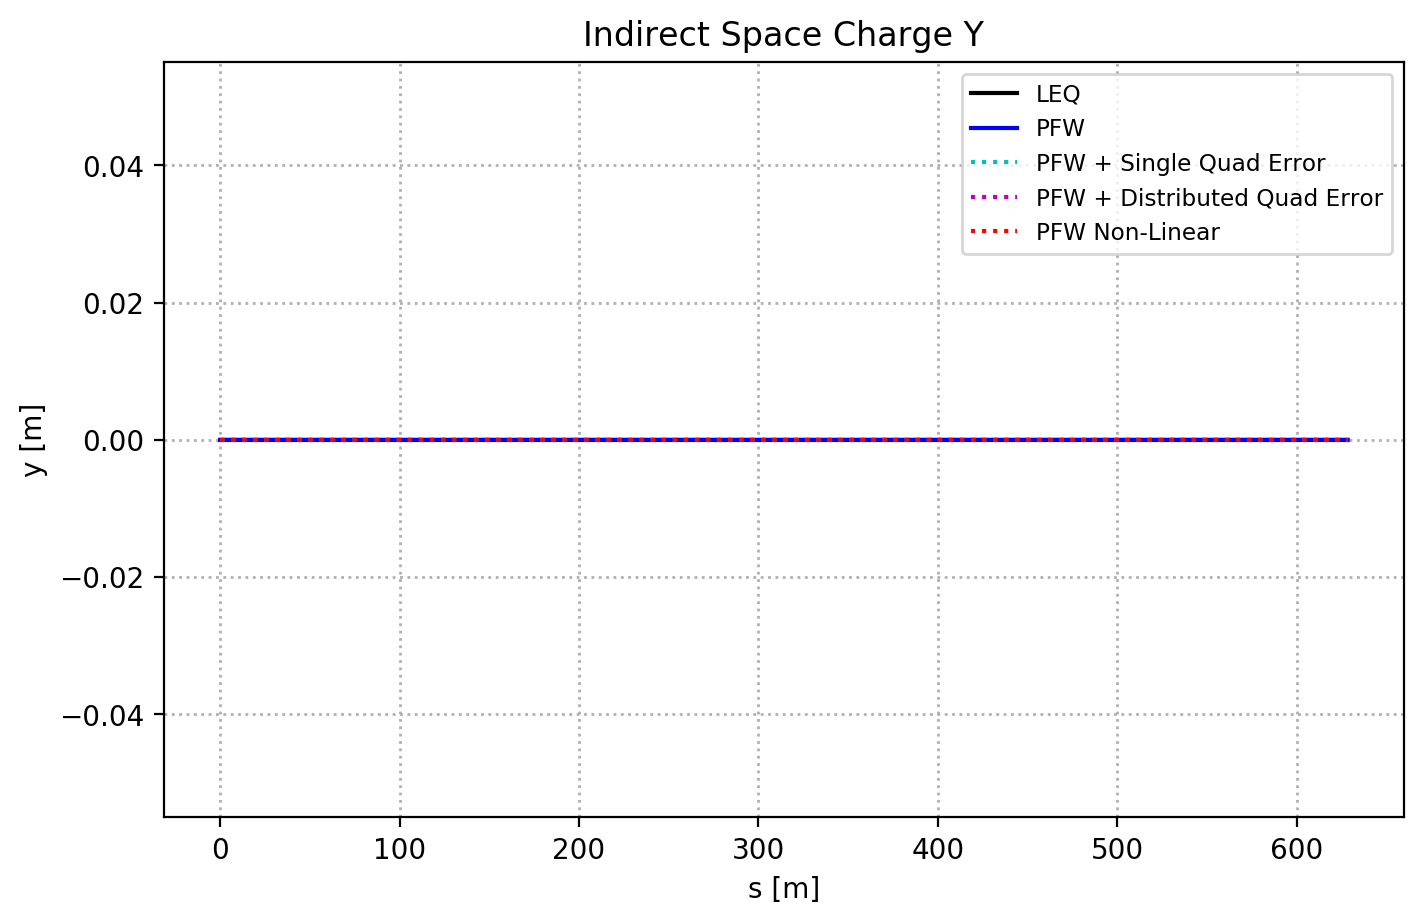

In [110]:
parameter = 'Y'

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel('y [m]');

ax1.plot(d_LEQ['S'], d_LEQ[parameter], label='LEQ', color='k');
ax1.plot(d_PFW['S'], d_PFW[parameter], label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], d_PFW_Single[parameter], label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], d_PFW_Distributed[parameter], label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], d_PFW_nonlin[parameter], label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

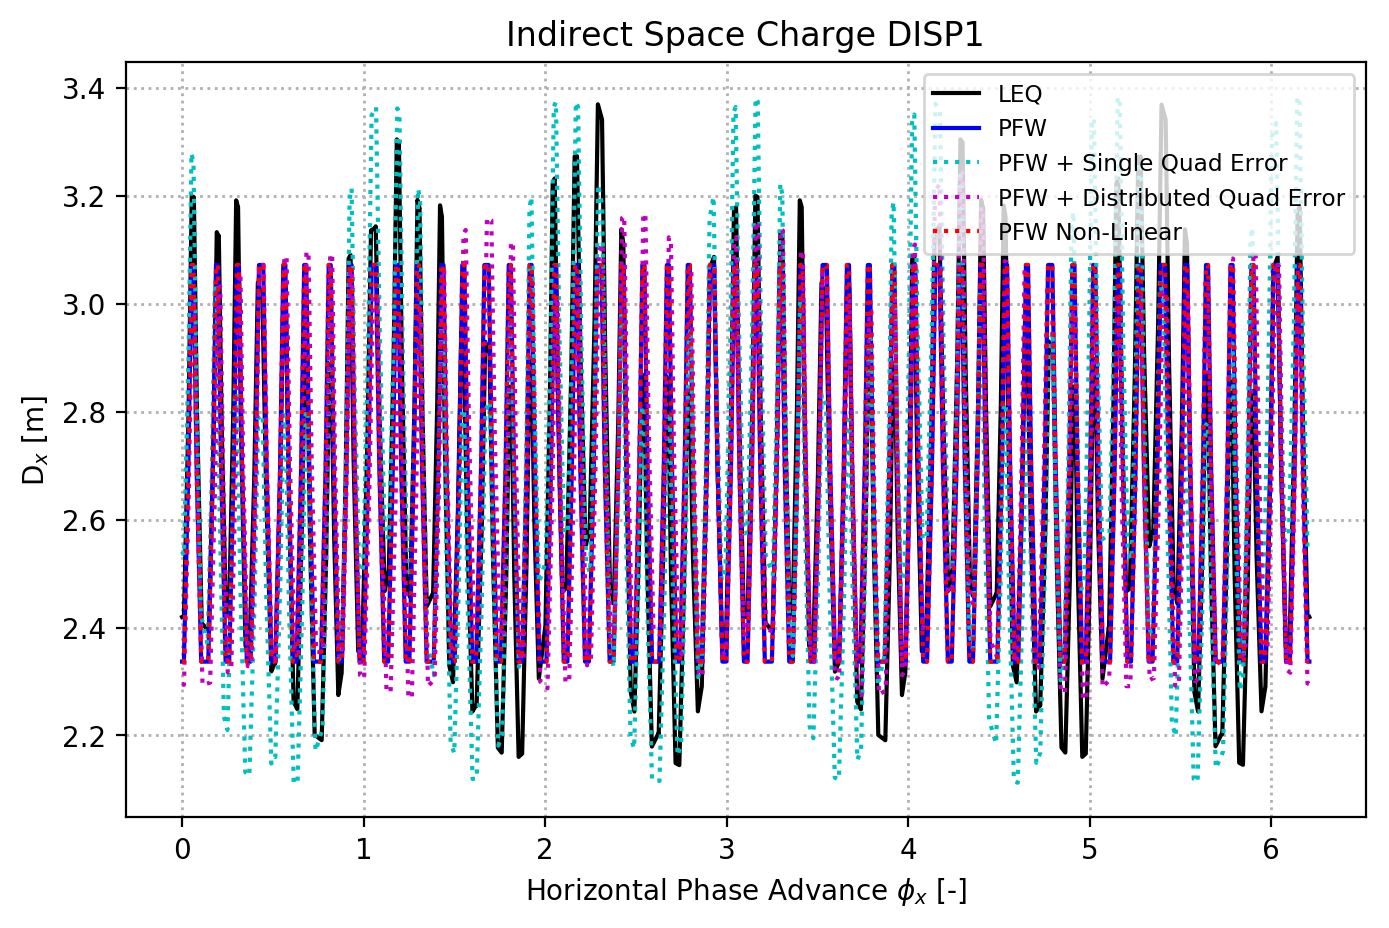

In [116]:
parameter = 'DISP1'
beta = 0.9158

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel(r'Horizontal Phase Advance $\phi_x$ [-]');
ax1.set_ylabel(r'D$_x$ [m]');

ax1.plot(d_LEQ['MU1'], np.array(d_LEQ[parameter])*beta, label='LEQ', color='k');
ax1.plot(d_PFW['MU1'], np.array(d_PFW[parameter])*beta, label='PFW', color='b');
ax1.plot(d_PFW_Single['MU1'], np.array(d_PFW_Single[parameter])*beta, label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['MU1'], np.array(d_PFW_Distributed[parameter])*beta, label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['MU1'], np.array(d_PFW_nonlin[parameter])*beta, label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '_2.png'
plt.savefig(savename, dpi = 200);

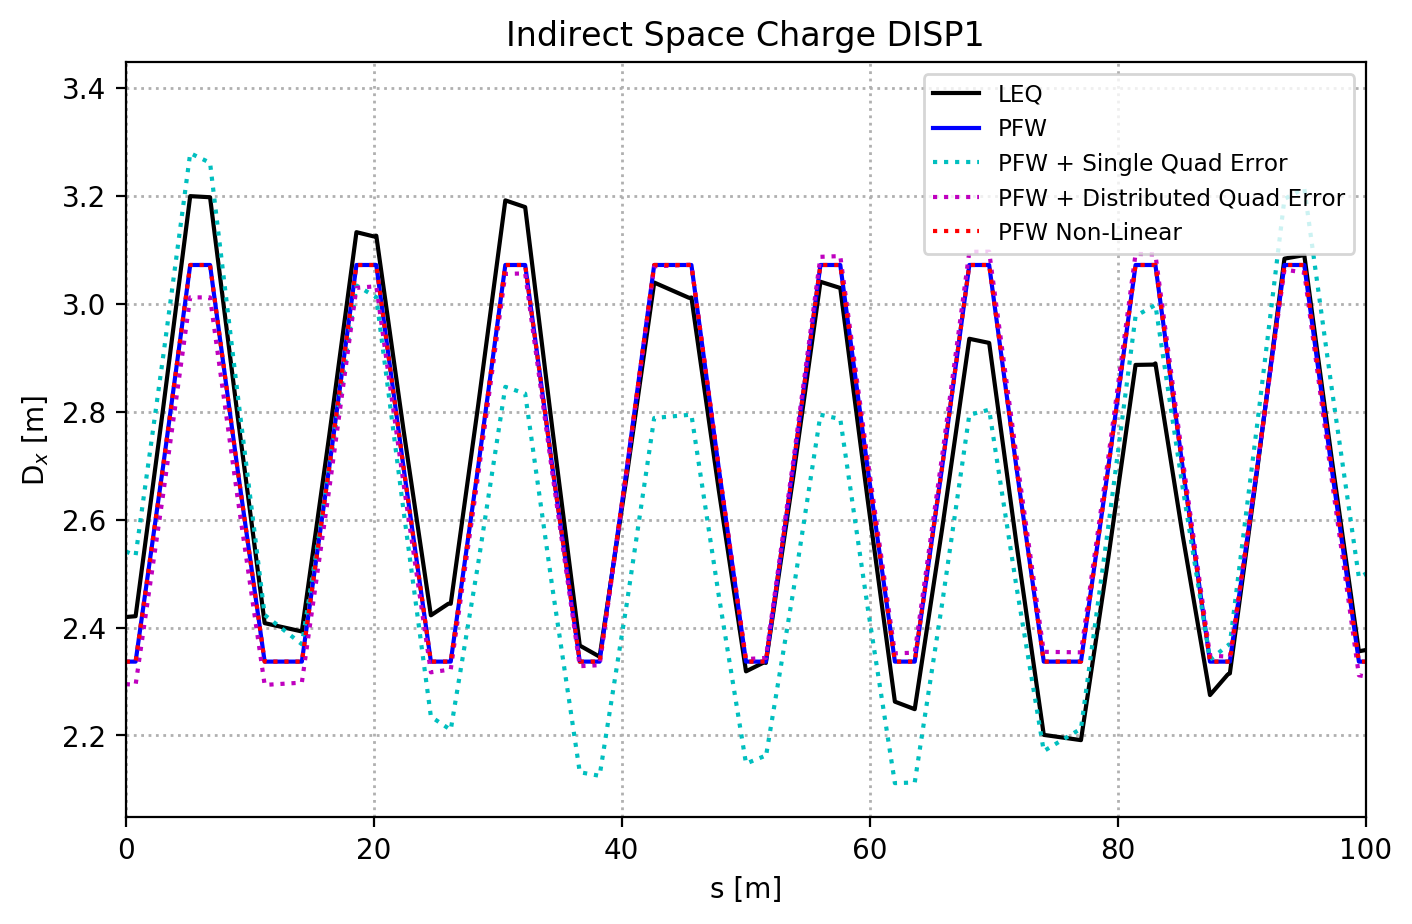

In [117]:
parameter = 'DISP1'
beta = 0.9158

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'D$_x$ [m]');

ax1.plot(d_LEQ['S'], np.array(d_LEQ[parameter])*beta, label='LEQ', color='k');
ax1.plot(d_PFW['S'], np.array(d_PFW[parameter])*beta, label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], np.array(d_PFW_Single[parameter])*beta, label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], np.array(d_PFW_Distributed[parameter])*beta, label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], np.array(d_PFW_nonlin[parameter])*beta, label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_xlim(0,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '_zoom.png'
plt.savefig(savename, dpi = 200);

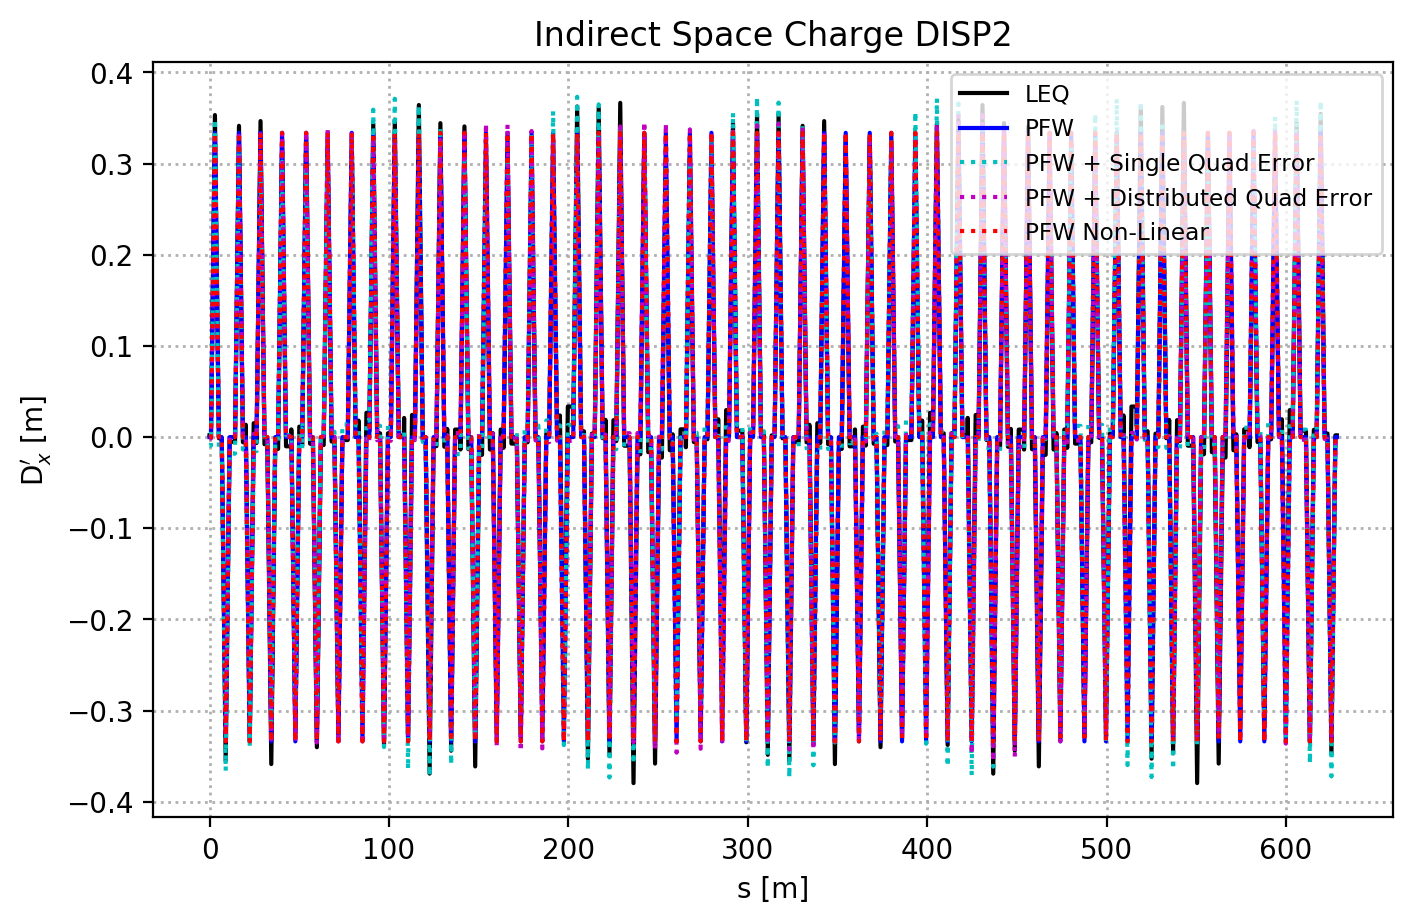

In [113]:
parameter = 'DISP2'
beta = 0.9158

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'D$_x^{\prime}$ [m]');

ax1.plot(d_LEQ['S'], np.array(d_LEQ[parameter])*beta, label='LEQ', color='k');
ax1.plot(d_PFW['S'], np.array(d_PFW[parameter])*beta, label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], np.array(d_PFW_Single[parameter])*beta, label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], np.array(d_PFW_Distributed[parameter])*beta, label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], np.array(d_PFW_nonlin[parameter])*beta, label='PFW Non-Linear', color='r', ls=':');
       
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

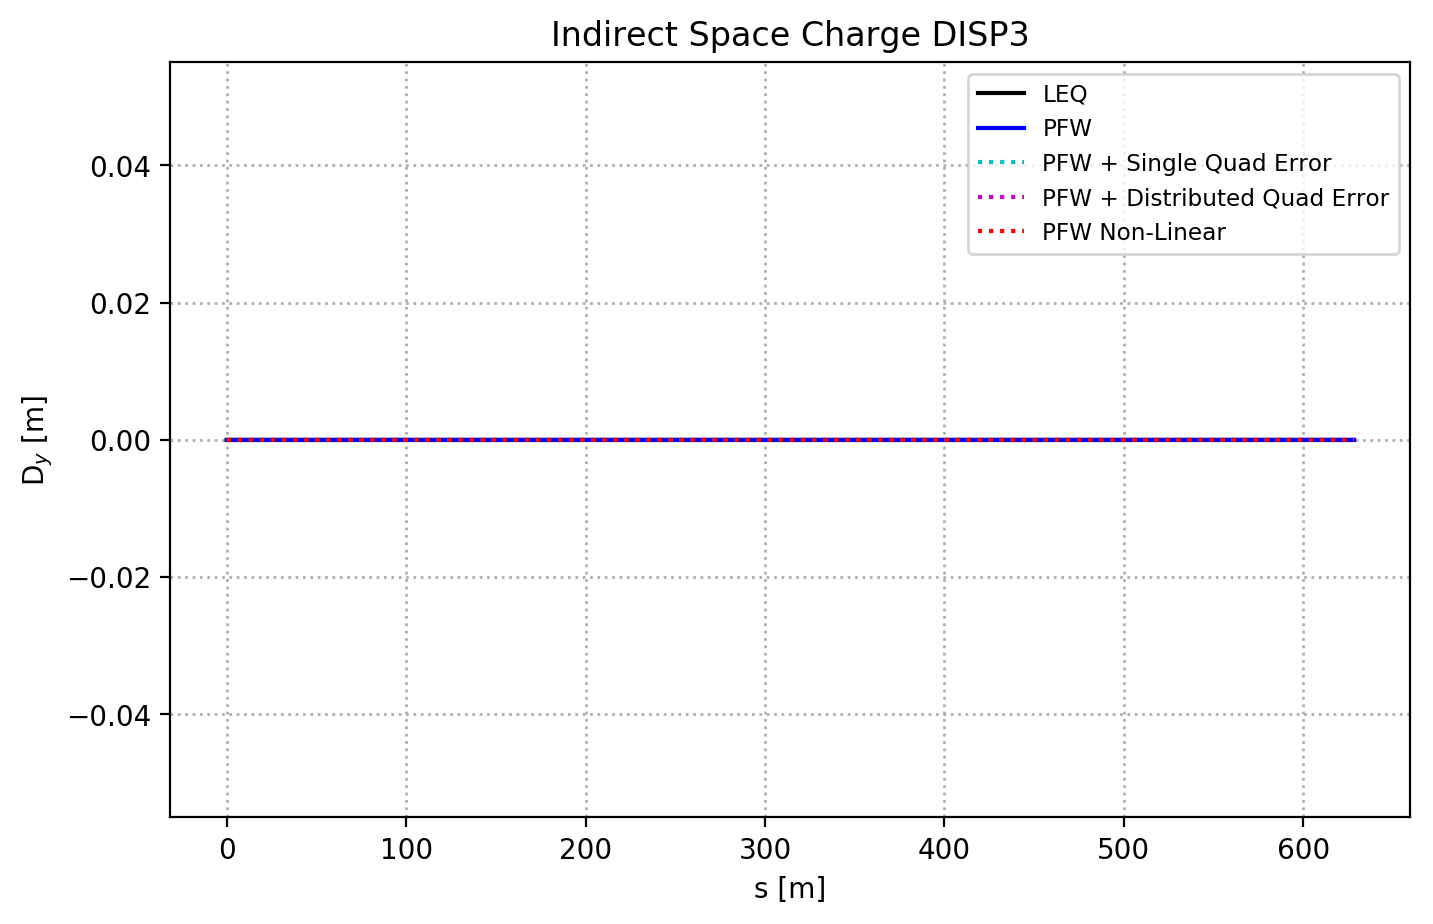

In [114]:
parameter = 'DISP3'
beta = 0.9158

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'D$_y$ [m]');

ax1.plot(d_LEQ['S'], np.array(d_LEQ[parameter])*beta, label='LEQ', color='k');
ax1.plot(d_PFW['S'], np.array(d_PFW[parameter])*beta, label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], np.array(d_PFW_Single[parameter])*beta, label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], np.array(d_PFW_Distributed[parameter])*beta, label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], np.array(d_PFW_nonlin[parameter])*beta, label='PFW Non-Linear', color='r', ls=':');
     
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

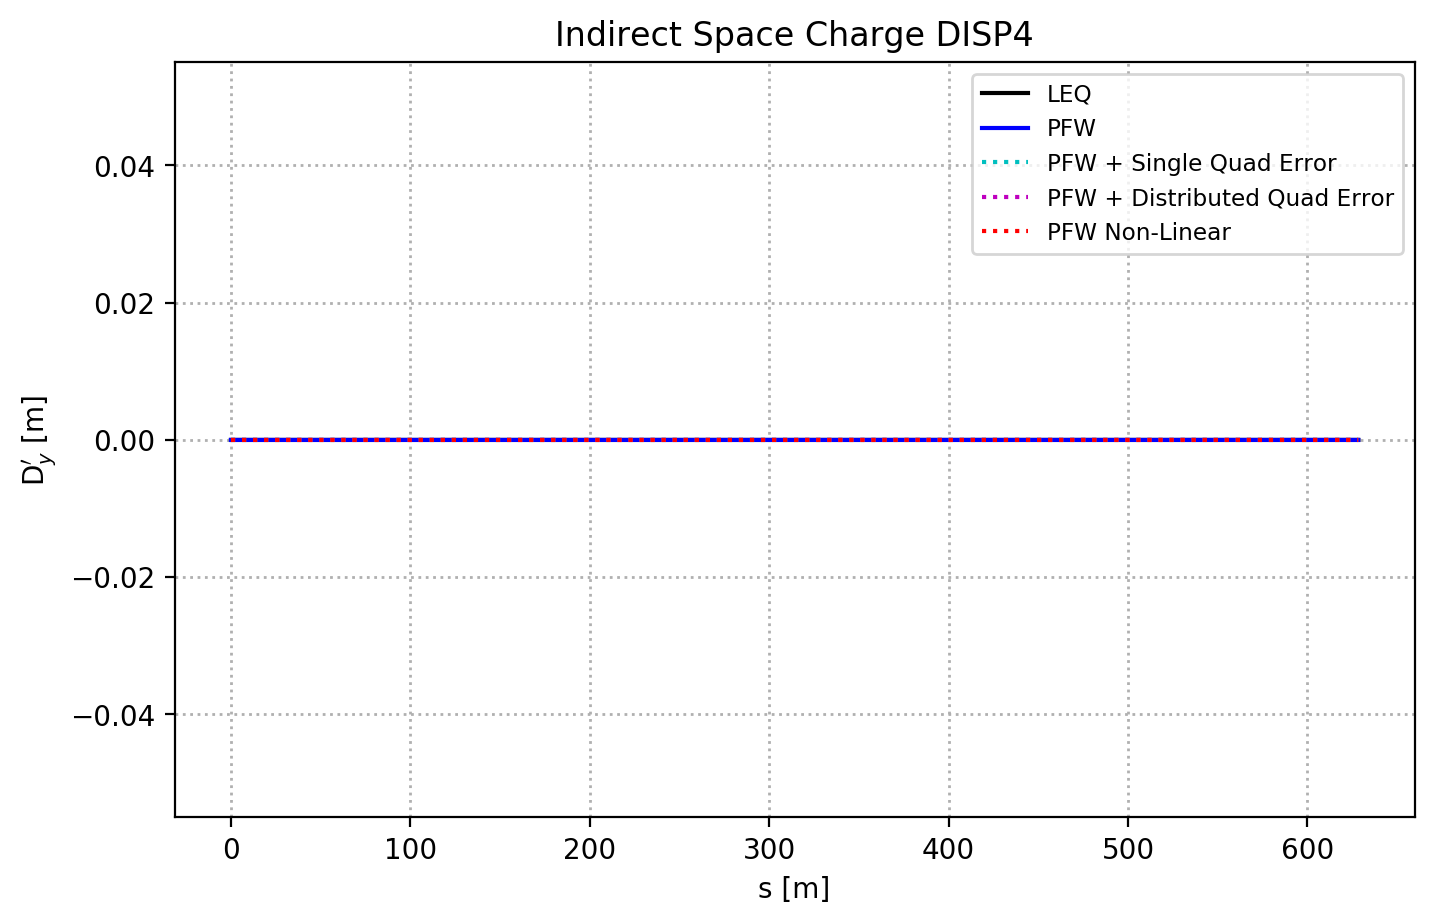

In [115]:
parameter = 'DISP4'
beta = 0.9158

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'D$_y^{\prime}$ [m]');

ax1.plot(d_LEQ['S'], np.array(d_LEQ[parameter])*beta, label='LEQ', color='k');
ax1.plot(d_PFW['S'], np.array(d_PFW[parameter])*beta, label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], np.array(d_PFW_Single[parameter])*beta, label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], np.array(d_PFW_Distributed[parameter])*beta, label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], np.array(d_PFW_nonlin[parameter])*beta, label='PFW Non-Linear', color='r', ls=':');
       
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
plt.savefig(savename, dpi = 200);

## Some important conclusions
- Using the LEQs (with respect to PFWs) generates optics perturbation due to the LEQs not being periodically positioned in the machine.
- Adding a single quadrupolar error in the PFW tune control lattice gives a similar magnitude of beta-beating.
- Adding a single quadrupolar error on the 20 QDNs in the PFW tune control lattice gives a similar magnitude of beta-beating.
- Including the non-linear fields (Sextupole and above) of the PFWs does not perturb the linear optics.

# Estimate bunch envelope size compared to average aperture

- $\epsilon_x$ = 1 mm mrad
- $\epsilon_y$ = 1.2 mm mrad

Using an elliptical aperture:
- full width = 0.73 m
- full height = 0.35 m

$$ \sigma_x = \sqrt{\beta_x \epsilon_x} $$

Use 3 $\sigma$ vs half-aperture

From simulations $\sigma_x \approx$ 3.55 mm, $\sigma_y \approx$ 3.32 mm at BWSV64 and our full bunch widths are around 4$\sigma$ in both planes. 

In [158]:
epsn_x = 1E-6
epsn_y = 1.2E-6

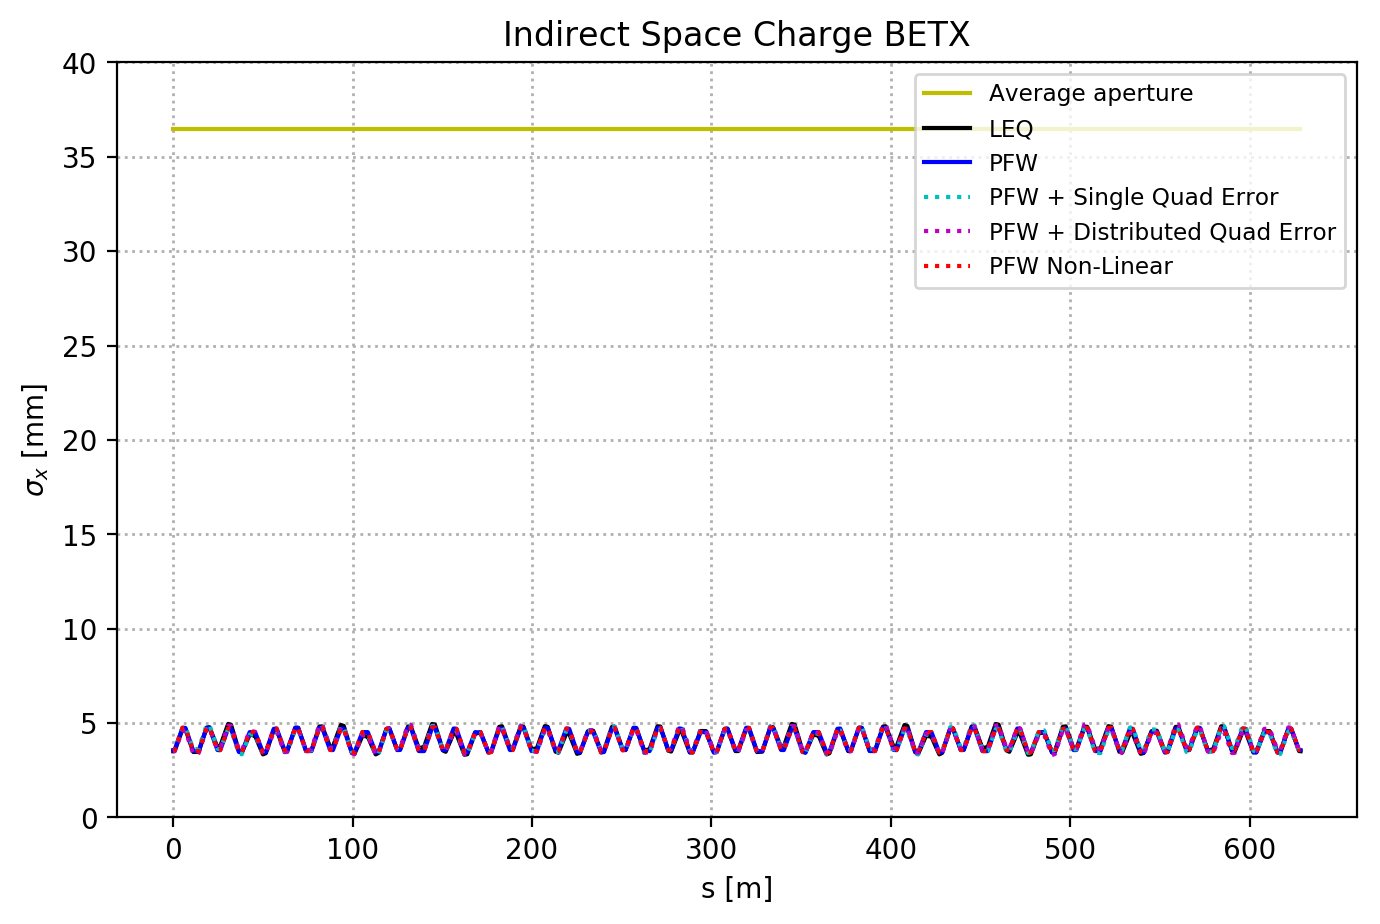

In [159]:
parameter = 'BETX'
multi = 1E3
n_sigma = 1.0

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\sigma_x$ [mm]');

x = np.array([0.,628.])
y = np.array([73/2.,73/2.])
ax1.plot(x,y, color = 'y', label= 'Average aperture')

#x = np.array([0.,628.])
#y = np.array([3.5E-3,3.5E-3])
#ax1.plot(x,y, label= 'Simulated beam size')

ax1.plot(d_LEQ['S'], multi*n_sigma*np.sqrt(np.array(d_LEQ[parameter])*epsn_x), label='LEQ', color='k');
ax1.plot(d_PFW['S'], multi*n_sigma*np.sqrt(np.array(d_PFW[parameter])*epsn_x), label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Single[parameter])*epsn_x), label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Distributed[parameter])*epsn_x), label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_nonlin[parameter])*epsn_x), label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(0,40)
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_x_beam_sigma_estimate.png'
plt.savefig(savename, dpi = 200);

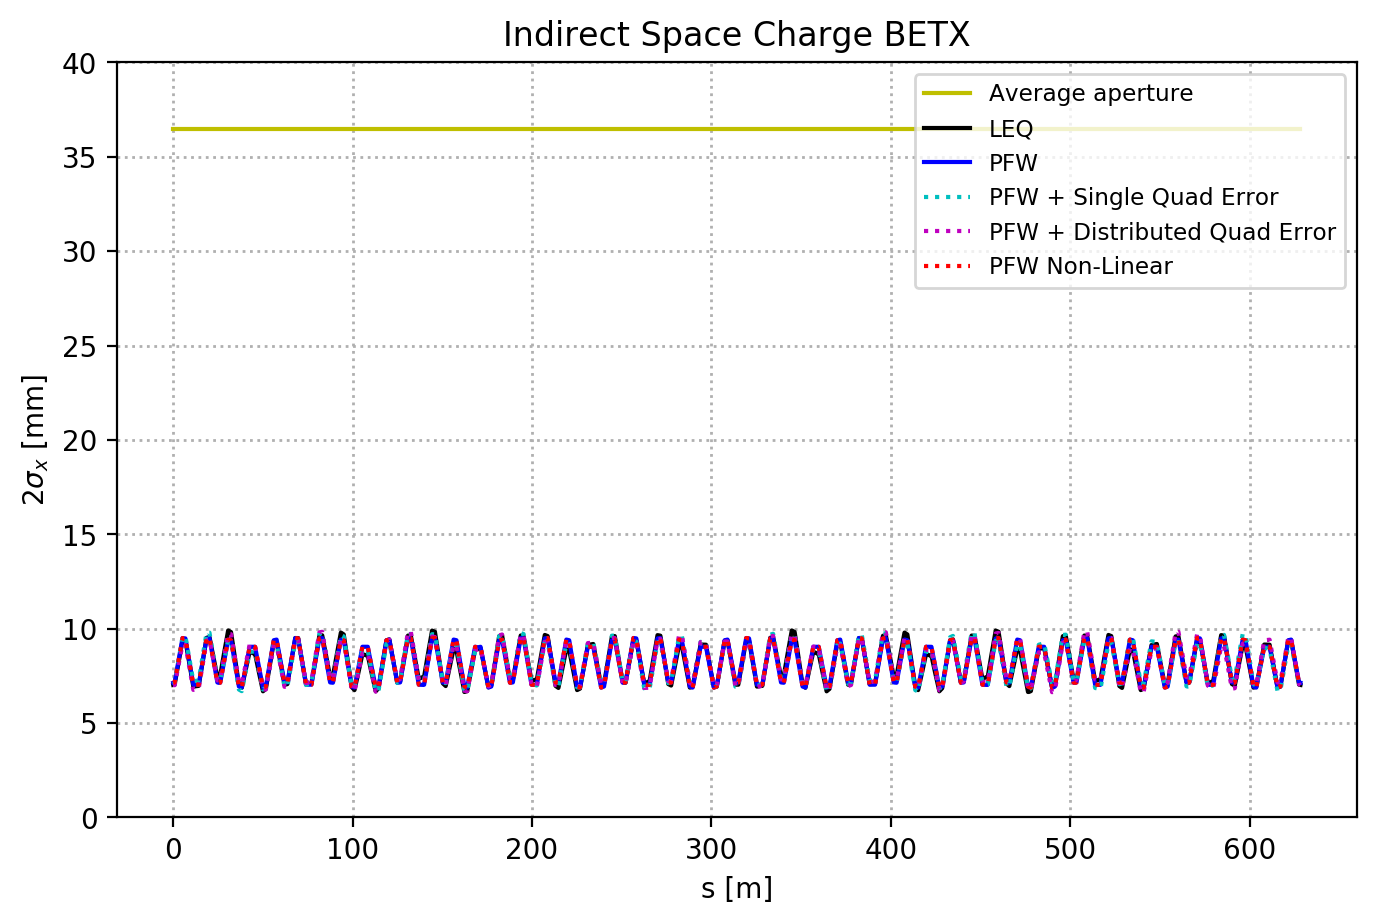

In [160]:
parameter = 'BETX'
multi = 1E3
n_sigma = 2.0

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$2 \sigma_x$ [mm]');

x = np.array([0.,628.])
y = np.array([73/2.,73/2.])
ax1.plot(x,y, color = 'y', label= 'Average aperture')

#x = np.array([0.,628.])
#y = np.array([3.5E-3,3.5E-3])
#ax1.plot(x,y, label= 'Simulated beam size')

ax1.plot(d_LEQ['S'], multi*n_sigma*np.sqrt(np.array(d_LEQ[parameter])*epsn_x), label='LEQ', color='k');
ax1.plot(d_PFW['S'], multi*n_sigma*np.sqrt(np.array(d_PFW[parameter])*epsn_x), label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Single[parameter])*epsn_x), label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Distributed[parameter])*epsn_x), label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_nonlin[parameter])*epsn_x), label='PFW Non-Linear', color='r', ls=':');
        
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(0,40)
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_x_beam_size_estimate.png'
plt.savefig(savename, dpi = 200);

- Currently we use 128 bins to cover ~ 20 mm beam-width
- To extend the same grid granularity over the boundary we have a factor ~ 36.5/10=3.65 
- Final bin size = 128 * 3.65 = 468

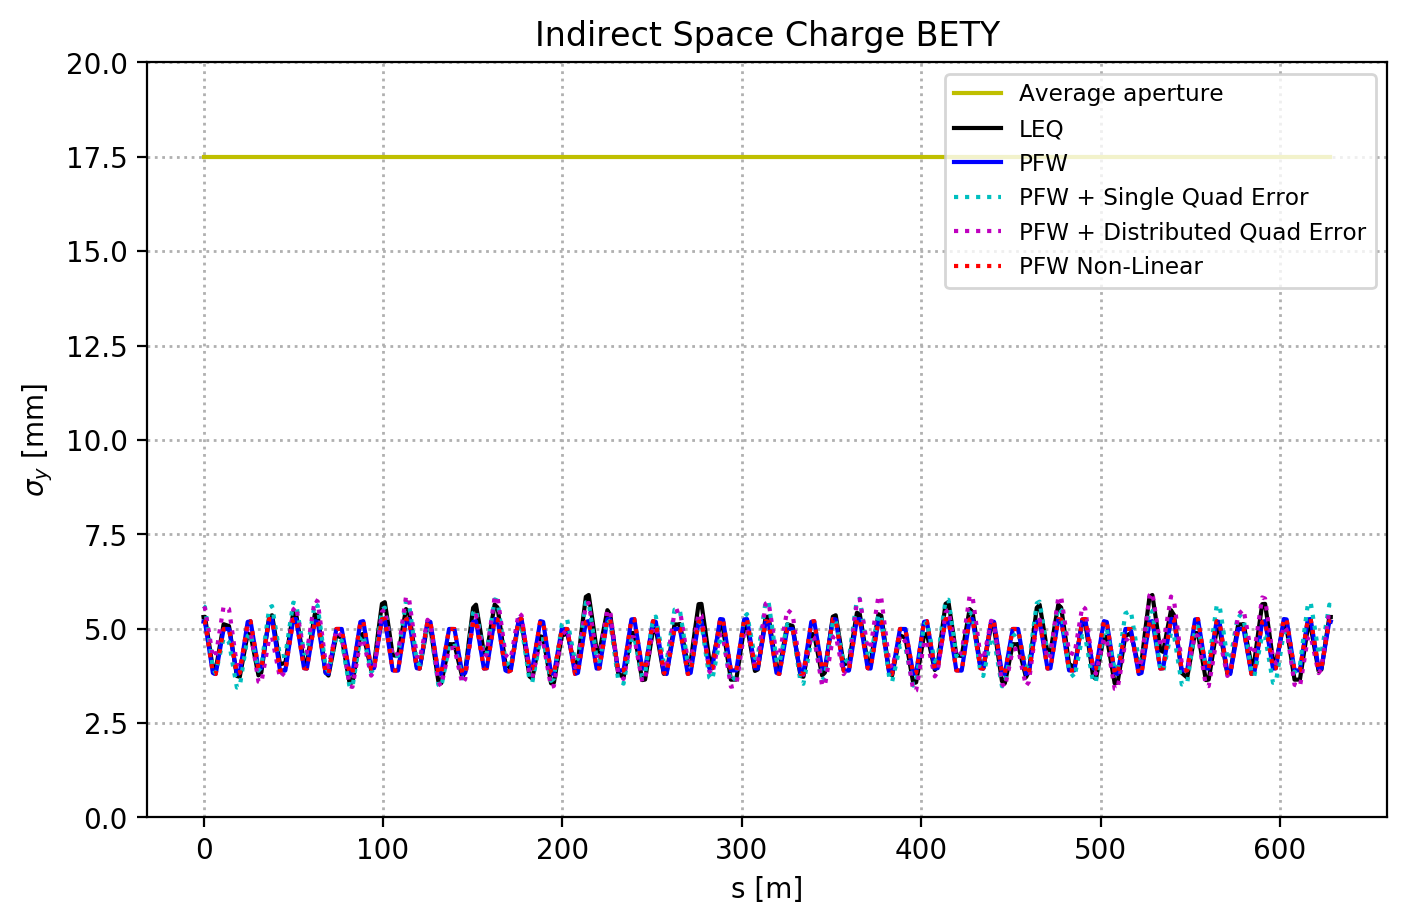

In [163]:
parameter = 'BETY'
multi = 1E3
n_sigma = 1.0

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$\sigma_y$ [mm]');

x = np.array([0.,628.])
y = np.array([35/2.,35/2.])
ax1.plot(x,y, color = 'y', label= 'Average aperture')

ax1.plot(d_LEQ['S'], multi*n_sigma*np.sqrt(np.array(d_LEQ[parameter])*epsn_y), label='LEQ', color='k');
ax1.plot(d_PFW['S'], multi*n_sigma*np.sqrt(np.array(d_PFW[parameter])*epsn_y), label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Single[parameter])*epsn_y), label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Distributed[parameter])*epsn_y), label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_nonlin[parameter])*epsn_y), label='PFW Non-Linear', color='r', ls=':');
     
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(0,20)
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_y_beam_sigma_estimate.png'
plt.savefig(savename, dpi = 200);

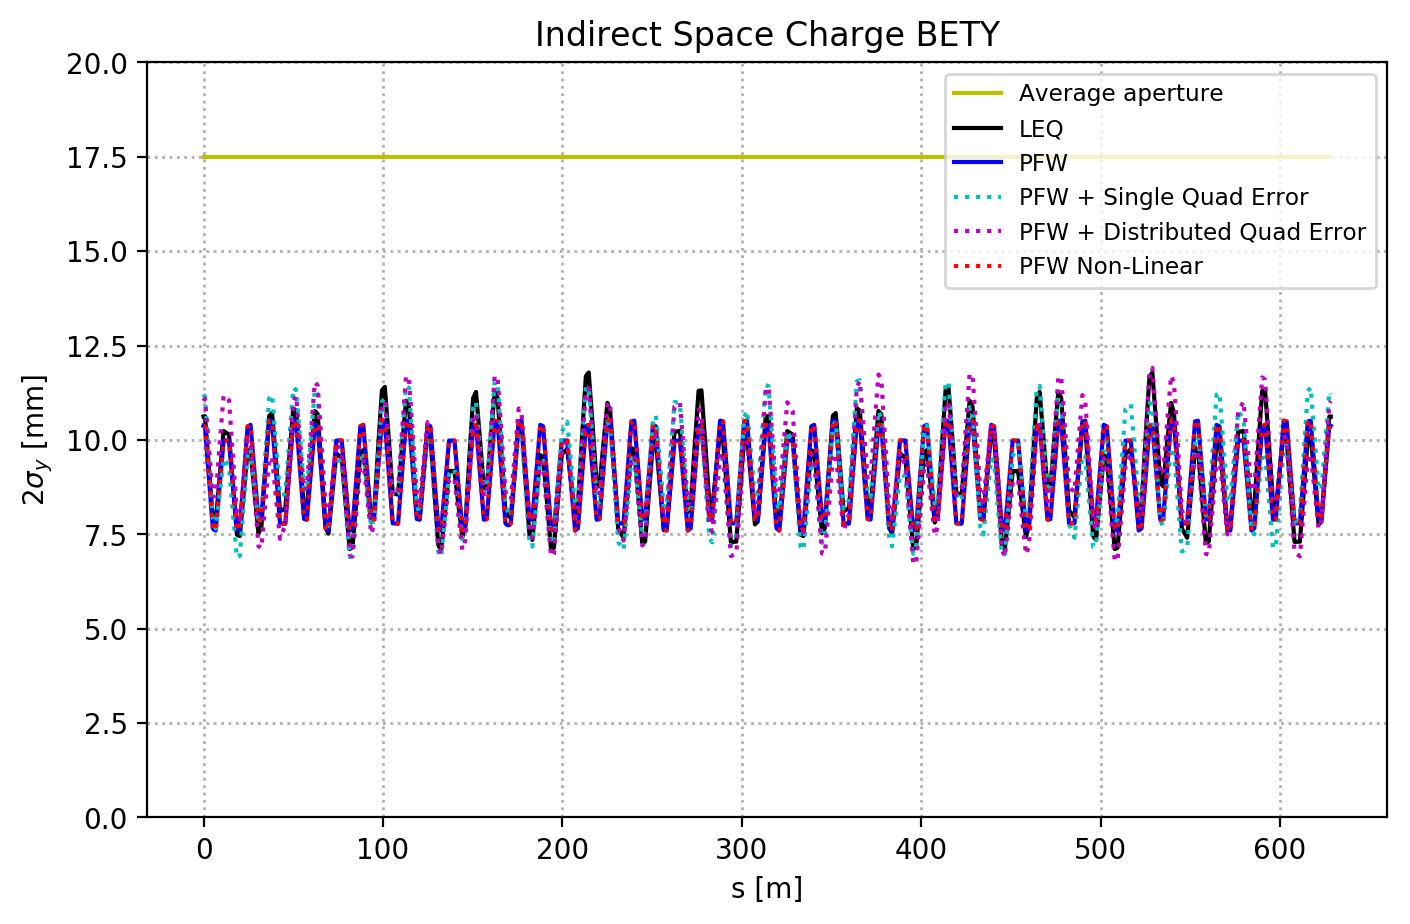

In [164]:
parameter = 'BETY'
multi = 1E3
n_sigma = 2.0

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = main_label + ' ' + parameter
ax1.set_title(tit);

ax1.set_xlabel('s [m]');
ax1.set_ylabel(r'$2 \sigma_y$ [mm]');

x = np.array([0.,628.])
y = np.array([35/2.,35/2.])
ax1.plot(x,y, color = 'y', label= 'Average aperture')

ax1.plot(d_LEQ['S'], multi*n_sigma*np.sqrt(np.array(d_LEQ[parameter])*epsn_y), label='LEQ', color='k');
ax1.plot(d_PFW['S'], multi*n_sigma*np.sqrt(np.array(d_PFW[parameter])*epsn_y), label='PFW', color='b');
ax1.plot(d_PFW_Single['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Single[parameter])*epsn_y), label='PFW + Single Quad Error', color='c', ls=':');
ax1.plot(d_PFW_Distributed['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_Distributed[parameter])*epsn_y), label='PFW + Distributed Quad Error', color='m', ls=':');
ax1.plot(d_PFW_nonlin['S'], multi*n_sigma*np.sqrt(np.array(d_PFW_nonlin[parameter])*epsn_y), label='PFW Non-Linear', color='r', ls=':');
     
ax1.legend(loc=1)
ax1.grid(lw=1, ls=':');
ax1.set_ylim(0,20)
#ax1.set_xlim(-10,100)

savename = save_folder + '/'+ main_label + '_y_beam_size_estimate.png'
plt.savefig(savename, dpi = 200);

- Currently we use 128 bins to cover ~ 25mm beam-height
- To extend the same grid granularity over the boundary we have a factor ~ 17.5/12.5 = 1.4 
- Final bin size = 128 * 1.4 = 180

# Estimated space chrage grid size to cover boundary and maintain granularity
- x = 468 (factor 3.65 increase)
- y = 180 (factor 1.4 increase)
- z = 64 (unchanged)